# H2O Demo

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## About the dataset

**Online Shopper's Intention** from kaggle.

https://www.kaggle.com/roshansharma/online-shoppers-intention/downloads/online-shoppers-intention.zip/1 

We want to predict whether or not an online user will make a purchase.

# Load and Review Data

In [2]:
#import file
path = os.getcwd()
df = pd.read_csv(path + '/online-shoppers-intention/online_shoppers_intention.csv')
print(df.shape)
df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# H2O

### Start Cluster

**H2O is designed to run on a desktop or scale with a cluster (Spark in our case).**

In [3]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)
  Starting server from C:\sigdev\anaconda\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DT225877\AppData\Local\Temp\tmpll1o3dtv
  JVM stdout: C:\Users\DT225877\AppData\Local\Temp\tmpll1o3dtv\h2o_dt225877_started_from_python.out
  JVM stderr: C:\Users\DT225877\AppData\Local\Temp\tmpll1o3dtv\h2o_dt225877_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,2 months and 10 days
H2O cluster name:,H2O_from_python_dt225877_4wa8z0
H2O cluster total nodes:,1
H2O cluster free memory:,3.511 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Read data into H2O dataframe and prep for training

**H2O has its own DataFrame format that stores files more efficiently than pandas (better in memory performance).  Dataframes can be created directly from files, Pandas DataFrames, or other objects.**

In [4]:
df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


**For classification, H2O Expects the target variable to be an "enum" which is the equivalent to a Factor in R.**

In [5]:
df['Revenue'].types

#convert revenue column to factor for classification models
#df['Revenue'] = df['Revenue'].asfactor()

{'Revenue': 'enum'}

**Create training and validation dataframes.**

In [6]:
train, test, valid = df.split_frame(ratios=[.80,.10], seed=123)
print('train: ', len(train))
print('test: ', len(test))
print('valid: ', len(valid))

train:  9909
test:  1194
valid:  1227


## Random Forest Model

**H2O models have the leading methodologies available.**
- parameter for defining how to handle categoricals (one hot encode, enum, etc)
- categorical binning
- row sampling
- different variations of column sampling
- parameter to add crossvalidation
- parameter to include validation set for evaluation
- balance classes / upsampling / downsampling
- automatically ignores columns that only have 1 unique value (faster training).

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

In [24]:
rf = h2o.estimators.H2ORandomForestEstimator(ntrees=15, 
                                             max_depth=5, 
                                             #min_rows=5, 
                                             nbins_cats=1024,
                                             mtries=5, 
                                             seed=123)
rf.train(y='Revenue', training_frame=train, validation_frame=valid)
print(rf.model_id)

drf Model Build progress: |███████████████████████████████████████████████| 100%
DRF_model_python_1570460720215_1701


## Model Evaluation

**Simple commands to veiw key metrics and visualize**

You can review metrics for the training set or the validation set

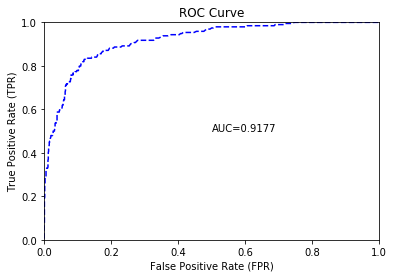

In [25]:
rf.model_performance(valid=True).plot()

In [26]:
rf.model_performance(valid=True)


ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.07639320486828928
RMSE: 0.27639320698651276
LogLoss: 0.2574437685641607
Mean Per-Class Error: 0.1450709074759733
AUC: 0.9177453318829154
pr_auc: 0.7376085556978321
Gini: 0.8354906637658308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31353547374407453: 


,False,True,Error,Rate
False,950.0,83.0,0.0803,(83.0/1033.0)
True,47.0,147.0,0.2423,(47.0/194.0)
Total,997.0,230.0,0.1059,(130.0/1227.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3135355,0.6933962,162.0
max f2,0.1907197,0.7587182,201.0
max f0point5,0.5039574,0.7178218,75.0
max accuracy,0.4322719,0.9013855,109.0
max precision,0.8016990,1.0,0.0
max recall,0.0273802,1.0,366.0
max specificity,0.8016990,1.0,0.0
max absolute_mcc,0.3135355,0.6332484,162.0
max min_per_class_accuracy,0.1400636,0.8412391,225.0
max mean_per_class_accuracy,0.1907197,0.8549291,201.0


Gains/Lift Table: Avg response rate: 15.81 %, avg score: 15.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0105949,0.7188800,6.3247423,6.3247423,1.0,0.7530068,1.0,0.7530068,0.0670103,0.0670103,532.4742268,532.4742268
,2,0.0203749,0.6640556,5.7976804,6.0717526,0.9166667,0.6987653,0.96,0.7269709,0.0567010,0.1237113,479.7680412,507.1752577
,3,0.0301548,0.6323587,6.3247423,6.1538033,1.0,0.6494469,0.9729730,0.7018279,0.0618557,0.1855670,532.4742268,515.3803288
,4,0.0407498,0.5874839,5.8382236,6.0717526,0.9230769,0.6099863,0.96,0.6779491,0.0618557,0.2474227,483.8223632,507.1752577
,5,0.0505297,0.5624733,4.2164948,5.7126704,0.6666667,0.5764921,0.9032258,0.6583123,0.0412371,0.2886598,321.6494845,471.2670436
,6,0.1002445,0.4699325,4.0436877,4.8849635,0.6393443,0.5182174,0.7723577,0.5888343,0.2010309,0.4896907,304.3687680,388.4963540
,7,0.1499593,0.3891474,3.0068447,4.2623263,0.4754098,0.4314939,0.6739130,0.5366726,0.1494845,0.6391753,200.6844685,326.2326311
,8,0.2004890,0.2806882,2.6523113,3.8565502,0.4193548,0.3401319,0.6097561,0.4871379,0.1340206,0.7731959,165.2311274,285.6550163
,9,0.2999185,0.1169128,0.9850008,2.9045691,0.1557377,0.1712475,0.4592391,0.3824134,0.0979381,0.8711340,-1.4999155,190.4569139
,10,0.4001630,0.0927503,0.4627860,2.2928801,0.0731707,0.1022653,0.3625255,0.3122337,0.0463918,0.9175258,-53.7213980,129.2880089


In [27]:
rf.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31353547374407453: 


,False,True,Error,Rate
False,950.0,83.0,0.0803,(83.0/1033.0)
True,47.0,147.0,0.2423,(47.0/194.0)
Total,997.0,230.0,0.1059,(130.0/1227.0)


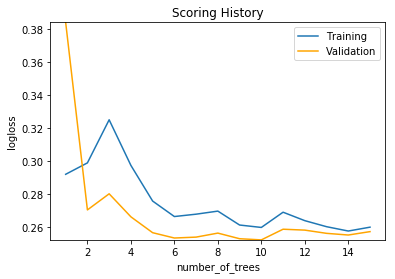

In [28]:
rf.plot()

In [29]:
rf.varimp(use_pandas=True).head()

,variable,relative_importance,scaled_importance,percentage
0,PageValues,3709.630615,1.000000,0.713484
1,ExitRates,504.743408,0.136063,0.097079
2,Month,202.278076,0.054528,0.038905
3,Administrative,176.123856,0.047477,0.033874
4,ProductRelated_Duration,173.583557,0.046793,0.033386


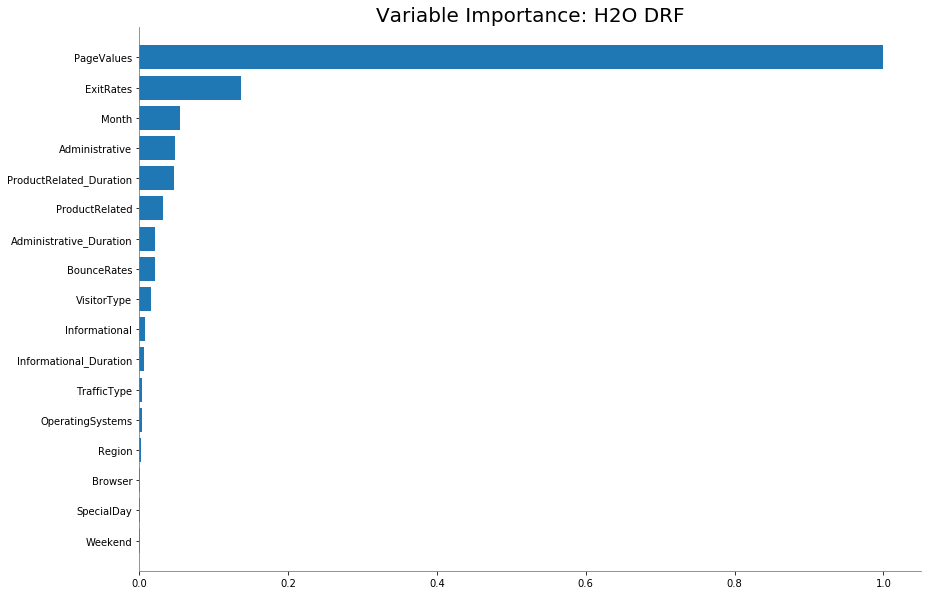

In [47]:
rf.varimp_plot(20)

### Grid Search Random Forest

In [40]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator

rf_params={'max_depth': [5,10],
          'mtries':[5,10],
          'min_rows':[1,2]}

rf_grid = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_grid',
                          hyper_params=rf_params)
rf_grid.train(y='Revenue',
                training_frame=train,
                validation_frame=valid,
                ntrees=15,
                seed=123)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [41]:
rf_grid.get_grid(sort_by='mean_per_class_error', decreasing=False)

     max_depth min_rows mtries          model_ids mean_per_class_error
0           10      2.0     10  rf_grid4_model_28  0.15084180796598837
1            6      1.0     17  rf_grid4_model_31  0.15454436582469236
2            9      2.0     10  rf_grid4_model_27  0.15566960409576752
3            6      1.0     10  rf_grid4_model_17  0.15598397221584615
4            6      2.0     10  rf_grid4_model_24  0.15662518338140338
5            9      1.0      5   rf_grid4_model_6  0.15665013323220328
6            7      2.0     10  rf_grid4_model_25  0.15695202642688197
7            6      2.0     17  rf_grid4_model_38  0.15727886947236056
8            8      2.0     10  rf_grid4_model_26  0.15873095078891428
9            7      1.0     10  rf_grid4_model_18  0.15904531890899293
10           4      1.0     10  rf_grid4_model_15  0.16065458428558596
11           4      2.0     10  rf_grid4_model_22  0.16065458428558596
12           5      1.0      5   rf_grid4_model_2  0.16130827037654316
13    

### Feature Contributions (SHAP Values)

#### Function to get top shap values

In [50]:
def get_contributions(data_for_pred, model, n_feats=3, pred_threshold=0.5):
    
    """
    
    Function to calculate the top n features that are driving the prediction value. The function returns a dataframe with predictions, column names for top features, 
    column values for top features, and prediction contribution for top features.
    
    Parameters
    ----------
    data_for_pred : H2O dataframe to get predictions and contributions for

    model : train H2O model.  Must be DRF or GBM
    
    n_feats : number of important features to return.  default=3.
    
    pred_threshold : Used to determine threshold for positive prediction explanations.  
    If prediction score is less than the threshold, features with the least contribution amounts will be returned.
    
    
    """
    
    #ensure parameters are present
   # if data_for_pred == None:
   #     return "missing prediction data"
   # elif model == None:
   #     return "missing model name"
    
    #calculate predictions
    predictions = model.predict(data_for_pred).as_data_frame(use_pandas=True)
    pred_proba = predictions.iloc[:,1]
    
    #calculate Shap contribution values using H2O predict_contributions
    contributions = model.predict_contributions(data_for_pred).as_data_frame(use_pandas=True)
    
    #drop BiasTerm to ensure it is not shown as a top feature to the user
    contributions.drop('BiasTerm', axis=1, inplace=True)
    
    # get indices for top  and bottom contributions
    bottom_contribution_indices = np.argsort(-contributions.values)[:,:n_feats]
    top_contribution_indices = np.argsort(contributions.values)[:,:n_feats]
    
    #create new array with top or bottom contribution indices based on threshold
    contribution_indices = bottom_contribution_indices.copy()
        
    # get the contribution value for the top features
    bottom_contribution_values = -np.sort(-contributions.values)[:,:n_feats]
    bottom_contribution_values = bottom_contribution_values.tolist()
    top_contribution_values = np.sort(contributions.values)[:,:n_feats]
    top_contribution_values = top_contribution_values.tolist()
    
    contribution_values = bottom_contribution_values  #changed this because I had it defaulting to top
    
    #loop through predictions and set values to top or bottom values based on threshold
    #defaulting to bottom values since most predictions will be false
    for i in range(len(pred_proba)):
        if pred_proba[i] >= pred_threshold:
            contribution_indices[i] = top_contribution_indices[i]
            contribution_values[i] = top_contribution_values[i]
    
    # get all contribution column names
    contribution_names = contributions.columns
    
    # get specific column names for contributions
    key_contribution_names = contribution_names[contribution_indices].tolist()
    
    #create pandas dataframe with data for prediction.  Need pandas to use index slicing and extract feature info.
    df = data_for_pred.as_data_frame(use_pandas=True)
    
    #get actual feature values from data_for_pred
    contribution_column_value = df[contribution_names.tolist()].values
    #identify values specifically for top features
    
    # get actual values for top features from prediction dataframe
    column_values = []

    for i in range(len(predictions)):    
        column_values.append(contribution_column_value[i, contribution_indices[i]])
    column_values = np.array(column_values).tolist()
    
    #combine feature information (column names, column values, and the contribution to the prediction)
    contribution_list = list(zip(key_contribution_names, column_values, contribution_values))
    
    #####Create dataframe with feature importance information #####
    
    #use loop to name columns depending on the number of features requested.
    feat_columns = []
    actual_val_cols = []
    contrib_amt_cols =[]
    column_order = []

    for count in range(3):  #this range is the number of feature explanations user requested
        #create new columns for the top n features requested
        feat_columns.append('feature_' + str(count))
        actual_val_cols.append('feature_' + str(count) + '_value')
        contrib_amt_cols.append('feature_' + str(count) + '_contrib_amt')

        #update list of column names to be referenced in next loop
        column_names = [feat_columns, actual_val_cols, contrib_amt_cols]

        for i in range(3): #this count should always be three because there are three columns reported for each feature
            #append column names in the order we want them to appear in the dataframe
            column_order.append(column_names[i][count])

    #define column names to be used in the dataframe.  These are not in order yet because they
    #must match the data being put in the dataframe
    columns = feat_columns + actual_val_cols + contrib_amt_cols

    #create dataframe with features
    pred_top_features_df = pd.DataFrame([[item for sublist in l for item in sublist] for l in contribution_list], columns = columns)

    #reorder dataframe to the preferred order
    pred_top_features_df = pred_top_features_df[column_order]

    #merge prepedictions with top feature info
    prediction_explanation_df = predictions.merge(pred_top_features_df, left_index=True, right_index=True)
    
    return(prediction_explanation_df)

#### Top Reasons for Predictions

**Raw SHAP Values**

In [58]:
#rf.predict_contributions(test[24:25,:]).as_data_frame(use_pandas=True)

**Use function to get top n SHAP values**

In [54]:
contributions = get_contributions(test[:100,:], rf, n_feats=3)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [55]:
contributions.sort_values(by='True', ascending=False).head(3)

,predict,False,True,feature_0,feature_0_value,feature_0_contrib_amt,feature_1,feature_1_value,feature_1_contrib_amt,feature_2,feature_2_value,feature_2_contrib_amt
24,True,0.270118,0.729882,PageValues,109.176,0.368710,ExitRates,0.00166667,0.088108,VisitorType,New_Visitor,0.076380
32,True,0.322853,0.677147,PageValues,51.4633,0.341587,ExitRates,0.00332986,0.096417,Administrative,0,0.081834
77,True,0.371875,0.628125,PageValues,45.4317,0.330482,Administrative,0,0.085870,ExitRates,0.0152273,0.077320


In [57]:
contributions.sort_values(by='True', ascending=True).head(3)

,predict,False,True,feature_0,feature_0_value,feature_0_contrib_amt,feature_1,feature_1_value,feature_1_contrib_amt,feature_2,feature_2_value,feature_2_contrib_amt
76,False,0.994723,0.005277,PageValues,0,-0.082613,Month,Mar,-0.028198,ExitRates,0.125,-0.009821
23,False,0.994723,0.005277,PageValues,0,-0.082879,Month,Mar,-0.028674,ExitRates,0.2,-0.010129
97,False,0.994723,0.005277,PageValues,0,-0.082612,Month,Mar,-0.027884,ExitRates,0.1,-0.012842


## Save Model

**H2O exports a MOJO or POJO Object.**  
- MOJOs/POJO are Java objects that include all of the necessary model info, java classes, and environment variables needed to run the model in productions. 
- To create the same performance in SKLearn you would want to create a Pipeline object, store environment variables (i.e. verions of sci-kit-learn, python and other libraries), and create function to handle values the model has not seen before.  All of the information would need to be loaded on a server for the model to work with an API.
- H2O also has a module called Sparkling Water that allows data scientists to use the H2O framework in Spark.  Users can save their model as a Spark Pipeline for later use in a Spark ETL job.

In [ ]:
#rf.save_mojo()

## K-Means

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/k-means.html

- estimate k option
- standardization is enabled default
- categorical encoding is enum/factor by default, this can be changed to one-hot if needed.
- automatically tracks key metrics, total sum of squares, within sum of squares, between sum of squares
- Centroid statistics (centroid number, size, within cluster sum of squares)

In [ ]:
#import data for example
diamonds = 'C:/Users/DT225877/Downloads/diamonds.csv'
clust_df = h2o.import_file(diamonds)

In [ ]:
kmeans = h2o.estimators.H2OKMeansEstimator(estimate_k=True, k=10, seed = 123)
kmeans.train(training_frame=clust_df)
kmeans.model_performance()

In [ ]:
kmeans.scoring_history().plot()

In [ ]:
clust_df['cluster']= kmeans.predict(clust_df)

In [ ]:
clust_df

## H2O Flow

http://localhost:54321